# Test PDPbox with binary classification problem
## Kaggle Titanic with XGBoost
This demo is based on **Titanic: Machine Learning from Disaster**  
https://www.kaggle.com/c/titanic/details/tutorials

In [59]:
%load_ext autoreload
%autoreload 2
import gc
import numpy as np
import pandas as pd
import sys
import re
from glob import glob
import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
#  sys.path.append(f"/mnt/c/Git/go/kaggle/github/library/")
import utils
from utils import logger_func, mkdir_func
logger = logger_func()
from utils import get_categorical_features, get_numeric_features, pararell_process
from tqdm import tqdm

%matplotlib inline

from pdpbox import pdp, get_dataset, info_plots

In [23]:
test_titanic = get_dataset.titanic()

In [27]:
titanic_data = test_titanic['data']
titanic_features = test_titanic['features']
titanic_model = test_titanic['xgb_model']
titanic_target = test_titanic['target']

In [66]:
type(titanic_features)

list

# get dataset and model

In [47]:
#========================================================================
# Global Variable
from info_home_credit import hcdr_key_cols
key, target, ignore_list = hcdr_key_cols()
#========================================================================

prev = utils.read_df_pkl(path='../input/clean_prev*.p')
base_app = utils.read_df_pkl(path='../input/base_app*')
prev = prev.merge(base_app, on=key, how='inner')

100%|██████████| 3/3 [00:00<00:00, 705.08it/s]


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     1696966      271877     Consumer loans    68258.655        1800000.0   
2     2154916      271877     Consumer loans    12417.390         108400.5   
3     2802425      108129         Cash loans    25188.615         607500.0   
4     1536272      108129         Cash loans    21709.125         450000.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               NaN          17145.0                   SATURDAY   
1   1754721.0          180000.0        1800000.0                   SATURDAY   
2    119848.5               NaN         108400.5                     SUNDAY   
3    679671.0               NaN         607500.0                   THURSDAY   
4    512370.0               NaN         450000.0                  WEDNESDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     18.0                           Y   
2                     14.0                           Y   
3                     11.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                NaN               0.182832   
1                     1.0           0.101325                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XAP              Refused   
2                       NaN                    XAP             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                    XNA             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0          -73.0  Cash through the bank                XAP             XNA   
1         -472.0  Cash through the bank                SCO             XNA   
2         -548.0  Cash through the bank                XAP             XNA   
3         -164.0                    XNA                XAP   Unaccompanied   
4         -515.0                    XNA                XAP             XNA   

  NAME_CLIENT_TYPE       NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater                    Mobile            POS               XNA   
1         Repeater  Clothing and Accessories            POS               XNA   
2              New                 Furniture            POS               XNA   
3         Repeater                       XNA           Cash            x-sell   
4         Repeater                       XNA           Cash            x-sell   

       CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0      Country-wide              35.0         Connectivity         12.0   
1  Regional / Local              55.0            Furniture         36.0   
2             Stone             196.0            Furniture         12.0   
3    Contact center              -1.0                  XNA         36.0   
4   AP+ (Cash loan)               6.0                  XNA         36.0   

  NAME_YIELD_GROUP         PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0           middle    POS mobile with interest                 NaN   
1       low_normal  POS industry with interest                 NaN   
2           middle  POS industry with interest                 NaN   
3       low_action            Cash X-Sell: low                 NaN   
4       low_normal            Cash X-Sell: low                 NaN   

   D

In [52]:
prev = prev[~prev[target].isnull()]
display(prev.head())

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     1696966      271877     Consumer loans    68258.655        1800000.0   
2     2154916      271877     Consumer loans    12417.390         108400.5   
3     2802425      108129         Cash loans    25188.615         607500.0   
4     1536272      108129         Cash loans    21709.125         450000.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               NaN          17145.0                   SATURDAY   
1   1754721.0          180000.0        1800000.0                   SATURDAY   
2    119848.5               NaN         108400.5                     SUNDAY   
3    679671.0               NaN         607500.0                   THURSDAY   
4    512370.0               NaN         450000.0                  WEDNESDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     18.0                           Y   
2                     14.0                           Y   
3                     11.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                NaN               0.182832   
1                     1.0           0.101325                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XAP              Refused   
2                       NaN                    XAP             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                    XNA             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0          -73.0  Cash through the bank                XAP             XNA   
1         -472.0  Cash through the bank                SCO             XNA   
2         -548.0  Cash through the bank                XAP             XNA   
3         -164.0                    XNA                XAP   Unaccompanied   
4         -515.0                    XNA                XAP             XNA   

  NAME_CLIENT_TYPE       NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater                    Mobile            POS               XNA   
1         Repeater  Clothing and Accessories            POS               XNA   
2              New                 Furniture            POS               XNA   
3         Repeater                       XNA           Cash            x-sell   
4         Repeater                       XNA           Cash            x-sell   

       CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0      Country-wide              35.0         Connectivity         12.0   
1  Regional / Local              55.0            Furniture         36.0   
2             Stone             196.0            Furniture         12.0   
3    Contact center              -1.0                  XNA         36.0   
4   AP+ (Cash loan)               6.0                  XNA         36.0   

  NAME_YIELD_GROUP         PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0           middle    POS mobile with interest                 NaN   
1       low_normal  POS industry with interest                 NaN   
2           middle  POS industry with interest                 NaN   
3       low_action            Cash X-Sell: low                 NaN   
4       low_normal            Cash X-Sell: low                 NaN   

   D

In [19]:
prev_target = prev['TARGET']
amt_credit = prev['AMT_CREDIT']
amt_annuity = prev['AMT_ANNUITY']
cnt_pay = prev['CNT_PAYMENT']
amt_application = prev['AMT_APPLICATION']
# ざっくり金利
prev['INTEREST_RATE'] = (prev['AMT_CREDIT'] - prev['AMT_APPLICATION']) / prev['AMT_APPLICATION']
prev['INTEREST_RATE_GOODS'] = (prev['AMT_CREDIT'] - prev['AMT_GOODS_PRICE']) / prev['AMT_GOODS_PRICE']
prev['AMT_INTEREST'] = prev['AMT_CREDIT'] - prev['AMT_APPLICATION']
prev['AMT_INTEREST_GOODS'] = prev['AMT_CREDIT'] - prev['AMT_GOODS_PRICE']
interest_rate = prev['INTEREST_RATE']
interest_rate_goods = prev['INTEREST_RATE_GOODS']
amt_interest = prev['AMT_INTEREST']
amt_interest_goods = prev['AMT_INTEREST_GOODS']

# 1. Binary feature: Sex

## 1.1 target distribution through feature 'Sex'

In [38]:
titanic_data[titanic_target].shape

(891,)

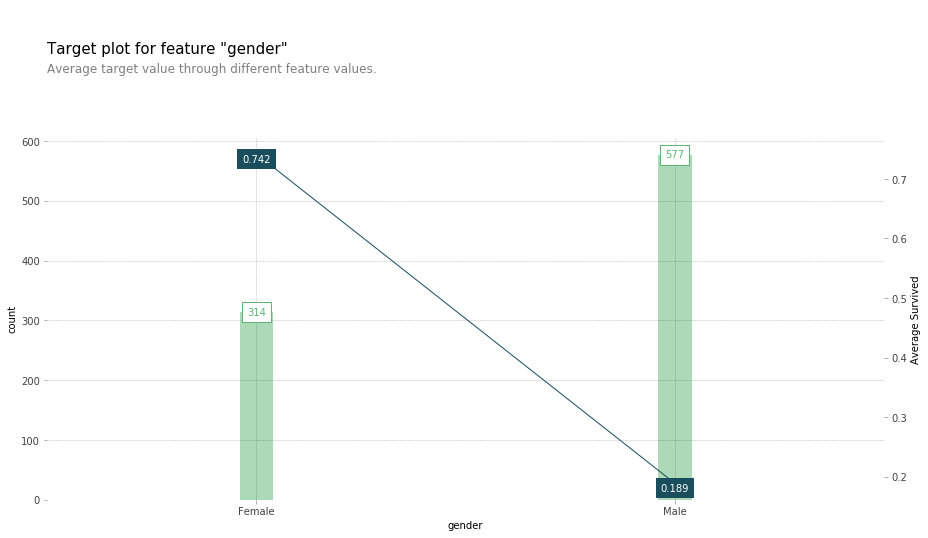

In [43]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature='Sex', feature_name='gender', target=titanic_target
)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])


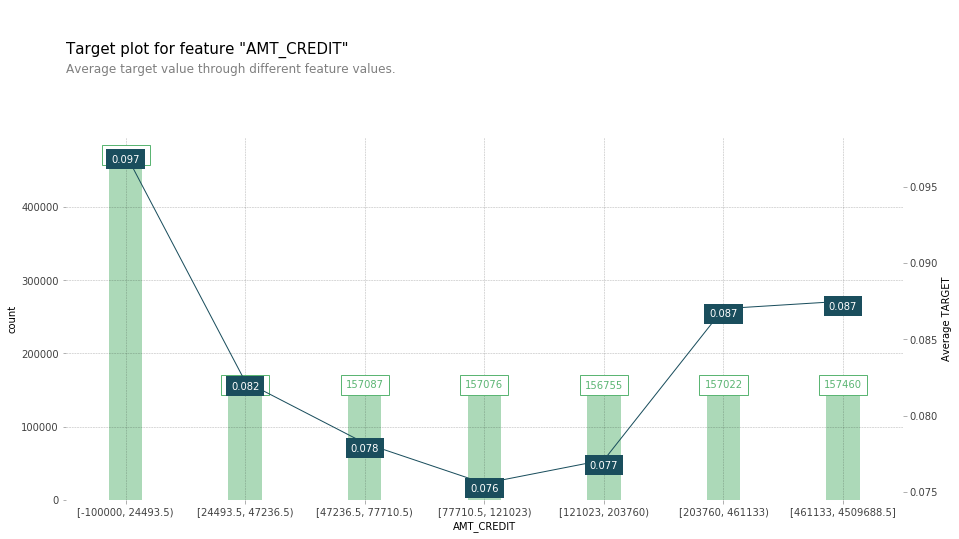

In [55]:
fig, axes, summary_df = info_plots.target_plot(
    df=prev.fillna(-100000), feature='AMT_CREDIT', feature_name='AMT_CREDIT', target=target
)
# _ = axes['bar_ax']
# .set_xticklabels(['Female', 'Male'])

In [56]:
summary_df

x       display_column  value_lower  value_upper   count    TARGET
0  0   [-100000, 24493.5)    -100000.0      24493.5  471233  0.097132
1  1   [24493.5, 47236.5)      24493.5      47236.5  157068  0.082232
2  2   [47236.5, 77710.5)      47236.5      77710.5  157087  0.078192
3  3    [77710.5, 121023)      77710.5     121023.0  157076  0.075556
4  4     [121023, 203760)     121023.0     203760.0  156755  0.077088
5  5     [203760, 461133)     203760.0     461133.0  157022  0.087001
6  6  [461133, 4509688.5]     461133.0    4509688.5  157460  0.087489

## 1.2 check prediction distribution through feature 'Sex'

In [64]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature='Sex', feature_name='gender'
)

AttributeError: 'XGBClassifier' object has no attribute 'kwargs'

In [8]:
summary_df

x display_column  count  actual_prediction_q1  actual_prediction_q2  \
0  0          Sex_0    314              0.567416              0.838413   
1  1          Sex_1    577              0.102959              0.126992   

   actual_prediction_q3  
0              0.927985  
1              0.230747

## 1.3 pdp for feature 'Sex'

In [9]:
pdp_sex = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Sex'
)

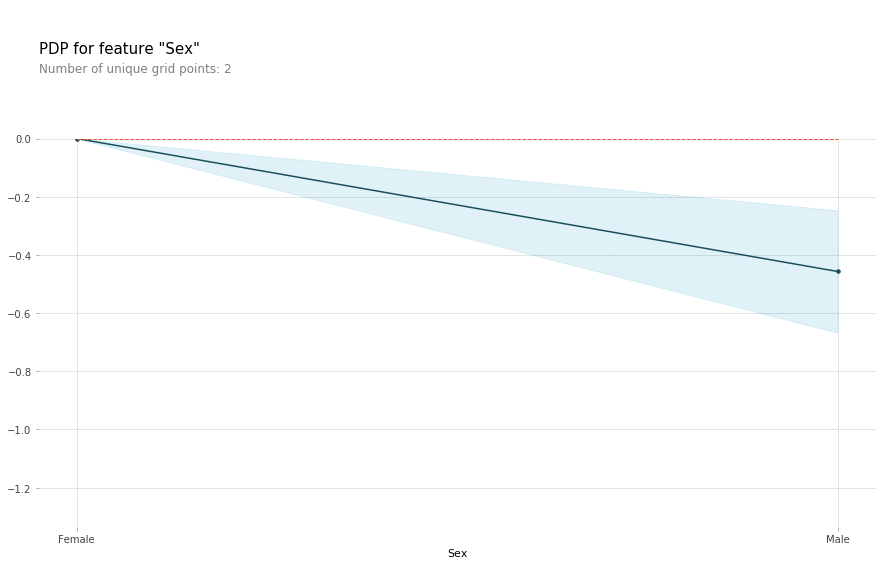

In [10]:
# default
fig, axes = pdp.pdp_plot(pdp_sex, 'Sex')
_ = axes['pdp_ax'].set_xticklabels(['Female', 'Male'])

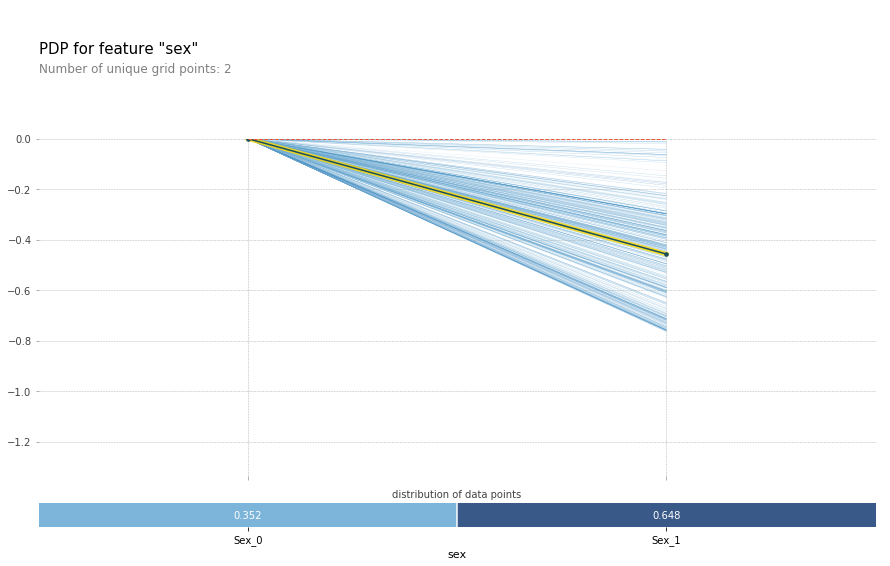

In [11]:
# more info
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

# 2. one-hot encoding feature: embarked
for one-hot encoding feature, should provide a list containing all the related columns

## 2.1 target distribution through feature 'embarked'

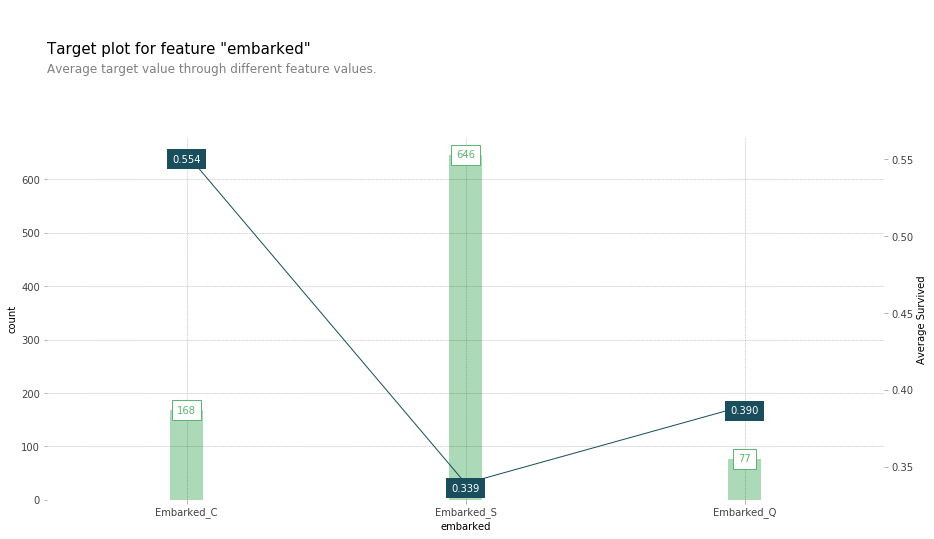

In [12]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], feature_name='embarked', 
    target=titanic_target
)

In [13]:
summary_df

x display_column  count  Survived
0  0     Embarked_C    168  0.553571
1  1     Embarked_S    646  0.339009
2  2     Embarked_Q     77  0.389610

## 2.2 check prediction distribution through feature 'embarked'

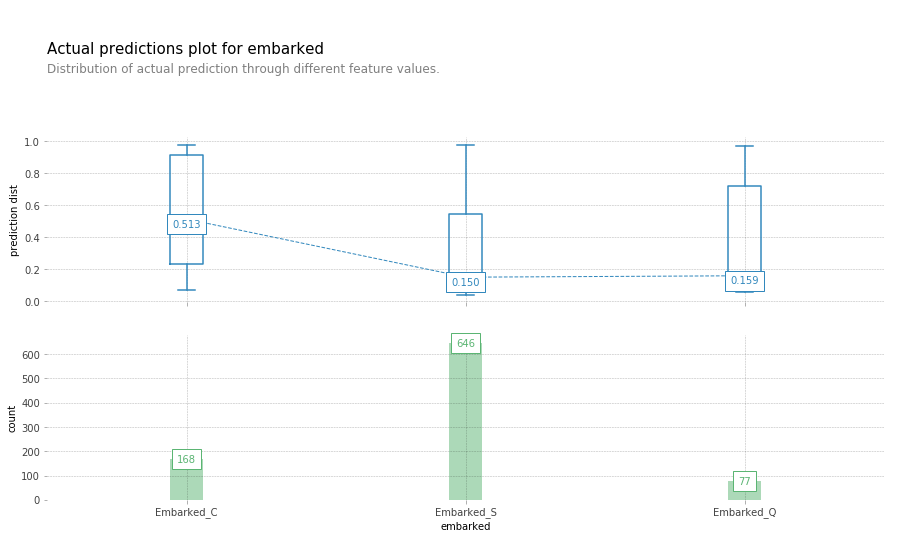

In [14]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], 
    feature_name='embarked'
)

In [15]:
summary_df

x display_column  count  actual_prediction_q1  actual_prediction_q2  \
0  0     Embarked_C    168              0.231351              0.513156   
1  1     Embarked_S    646              0.109424              0.150355   
2  2     Embarked_Q     77              0.115931              0.159242   

   actual_prediction_q3  
0              0.912702  
1              0.545072  
2              0.720176

## 2.3 pdp for feature 'embarked'

In [16]:
pdp_embark = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, 
    feature=['Embarked_C', 'Embarked_S', 'Embarked_Q']
)

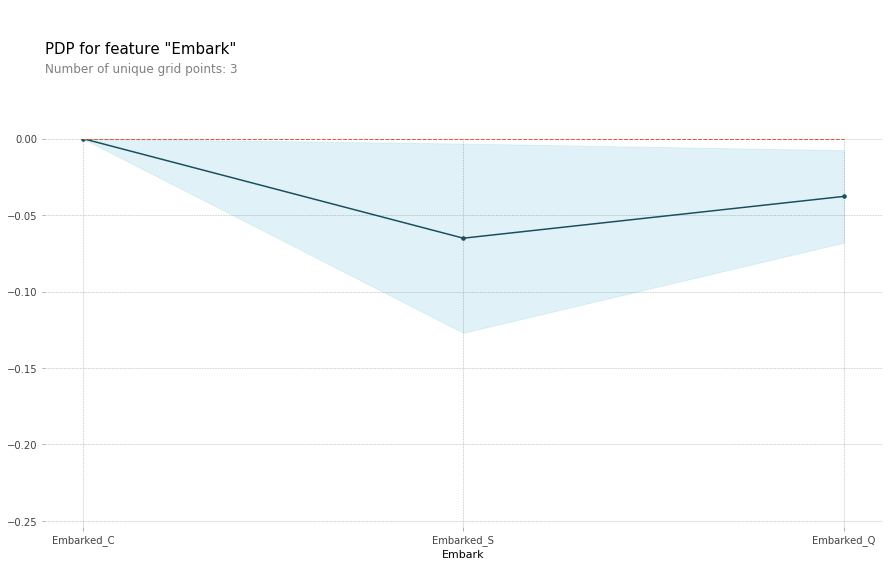

In [17]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark')

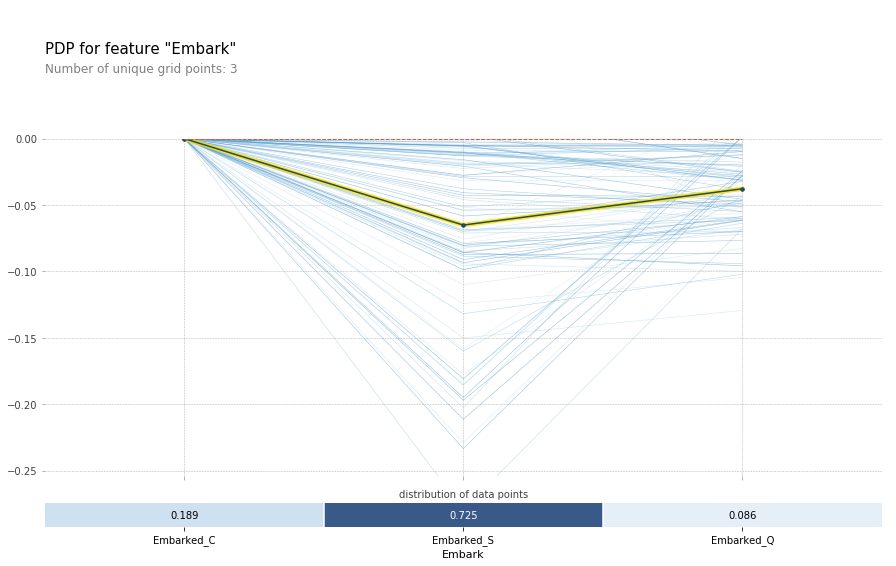

In [18]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 3. numeric feature: Fare

## 3.1 target distribution through feature 'Fare'

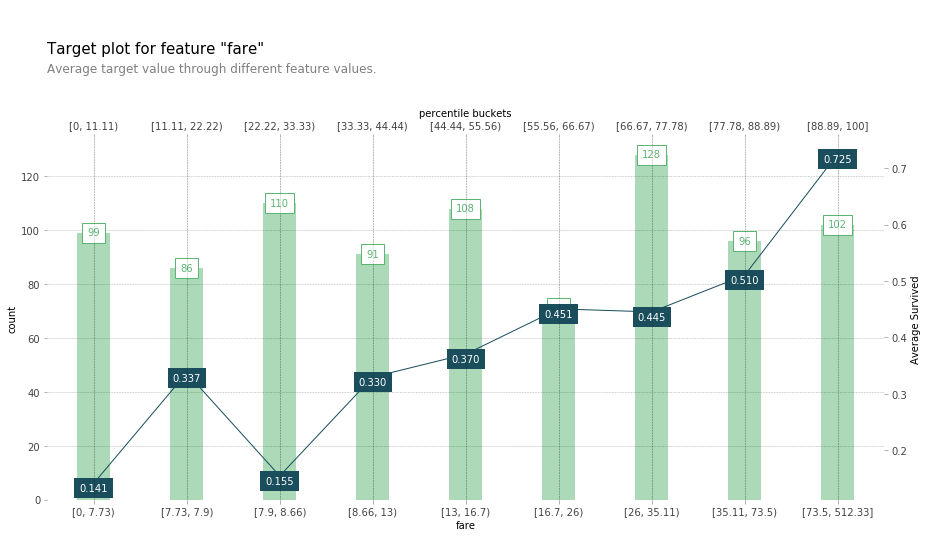

In [19]:
fig, axes, summary_df = info_plots.target_plot(
    df=titanic_data, feature='Fare', feature_name='fare', target=titanic_target, show_percentile=True
)

In [20]:
summary_df

x  display_column  value_lower  value_upper percentile_column  \
0  0       [0, 7.73)     0.000000     7.732844        [0, 11.11)   
1  1     [7.73, 7.9)     7.732844     7.895800    [11.11, 22.22)   
2  2     [7.9, 8.66)     7.895800     8.662500    [22.22, 33.33)   
3  3      [8.66, 13)     8.662500    13.000000    [33.33, 44.44)   
4  4      [13, 16.7)    13.000000    16.700000    [44.44, 55.56)   
5  5      [16.7, 26)    16.700000    26.000000    [55.56, 66.67)   
6  6     [26, 35.11)    26.000000    35.111111    [66.67, 77.78)   
7  7   [35.11, 73.5)    35.111111    73.500000    [77.78, 88.89)   
8  8  [73.5, 512.33]    73.500000   512.329200      [88.89, 100]   

   percentile_lower  percentile_upper  count  Survived  
0              0.00             11.11     99  0.141414  
1             11.11             22.22     86  0.337209  
2             22.22             33.33    110  0.154545  
3             33.33             44.44     91  0.329670  
4             44.44             55.56    108  0.370370  
5             55.56             66.67     71  0.450704  
6             66.67             77.78    128  0.445312  
7             77.78             88.89     96  0.510417  
8             88.89            100.00    102  0.725490

## 3.2 check prediction distribution through feature 'Fare'

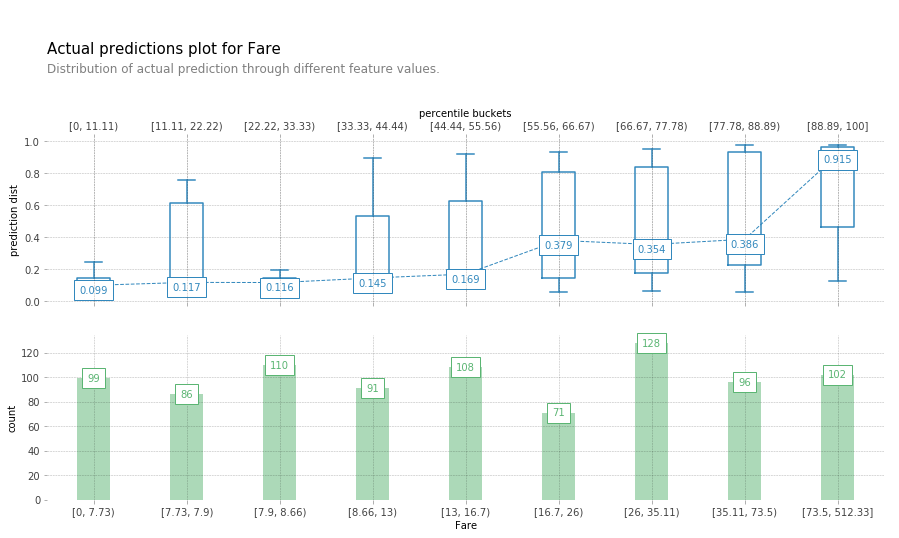

In [21]:
fig, axes, summary_df = info_plots.actual_plot(
    model=titanic_model, X=titanic_data[titanic_features], feature='Fare', feature_name='Fare', 
    show_percentile=True
)

In [22]:
summary_df

x  display_column  value_lower  value_upper percentile_column  \
0  0       [0, 7.73)     0.000000     7.732844        [0, 11.11)   
1  1     [7.73, 7.9)     7.732844     7.895800    [11.11, 22.22)   
2  2     [7.9, 8.66)     7.895800     8.662500    [22.22, 33.33)   
3  3      [8.66, 13)     8.662500    13.000000    [33.33, 44.44)   
4  4      [13, 16.7)    13.000000    16.700000    [44.44, 55.56)   
5  5      [16.7, 26)    16.700000    26.000000    [55.56, 66.67)   
6  6     [26, 35.11)    26.000000    35.111111    [66.67, 77.78)   
7  7   [35.11, 73.5)    35.111111    73.500000    [77.78, 88.89)   
8  8  [73.5, 512.33]    73.500000   512.329200      [88.89, 100]   

   percentile_lower  percentile_upper  count  actual_prediction_q1  \
0              0.00             11.11     99              0.069861   
1             11.11             22.22     86              0.107916   
2             22.22             33.33    110              0.098939   
3             33.33             44.44     91              0.114593   
4             44.44             55.56    108              0.122154   
5             55.56             66.67     71              0.146319   
6             66.67             77.78    128              0.175587   
7             77.78             88.89     96              0.223087   
8             88.89            100.00    102              0.460539   

   actual_prediction_q2  actual_prediction_q3  
0              0.099070              0.142362  
1              0.117240              0.614474  
2              0.116362              0.146534  
3              0.144842              0.530937  
4              0.168968              0.626364  
5              0.379385              0.805452  
6              0.353853              0.835547  
7              0.386497              0.929101  
8              0.914678              0.959526

## 3.3 pdp for feature 'Fare'

In [23]:
pdp_fare = pdp.pdp_isolate(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Fare'
)

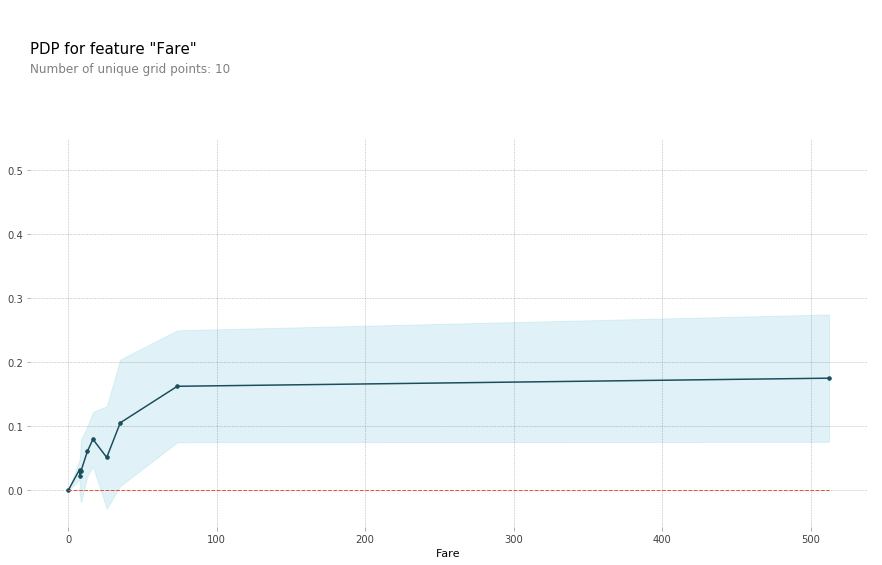

In [24]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare')

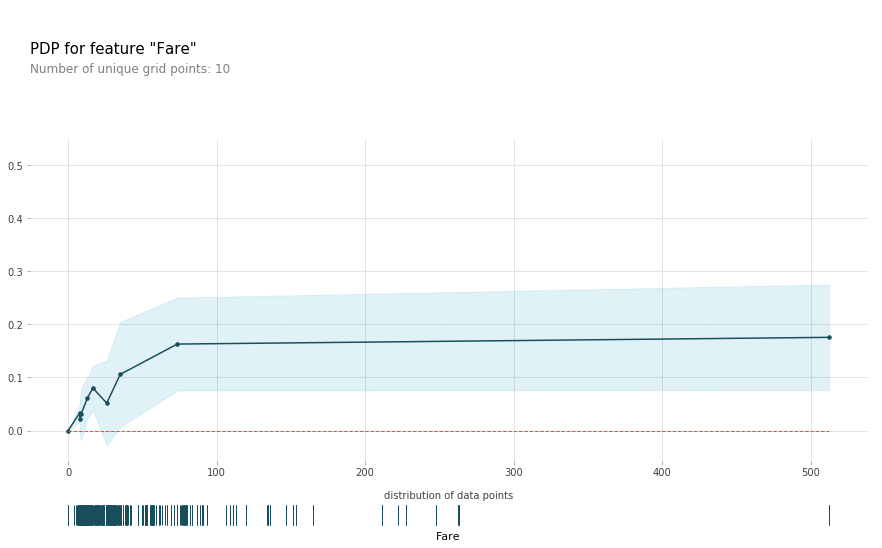

In [25]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare', plot_pts_dist=True)

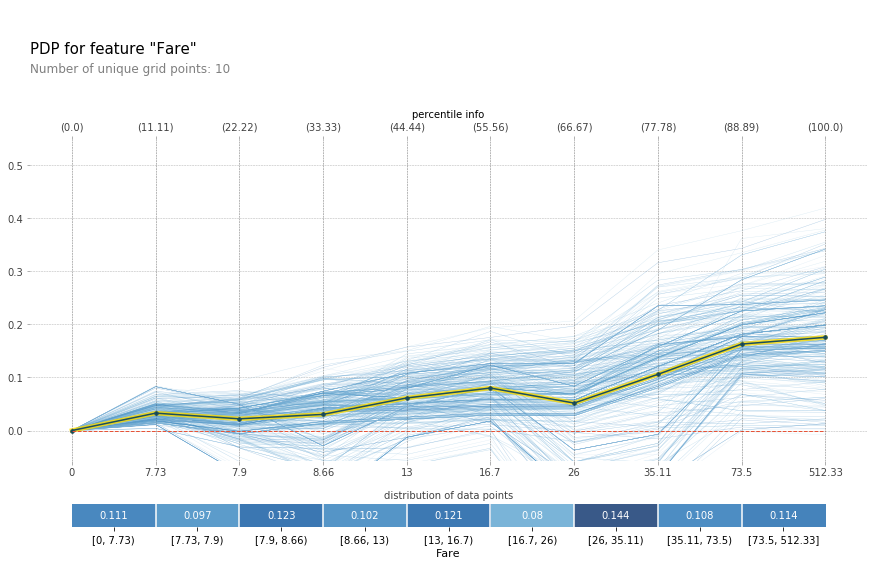

In [26]:
fig, axes = pdp.pdp_plot(
    pdp_fare, 'Fare', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
)

# 4. Interaction between two variables: Age and Fare

## 4.1 target distribution through feature combination of 'Age' and 'Fare'

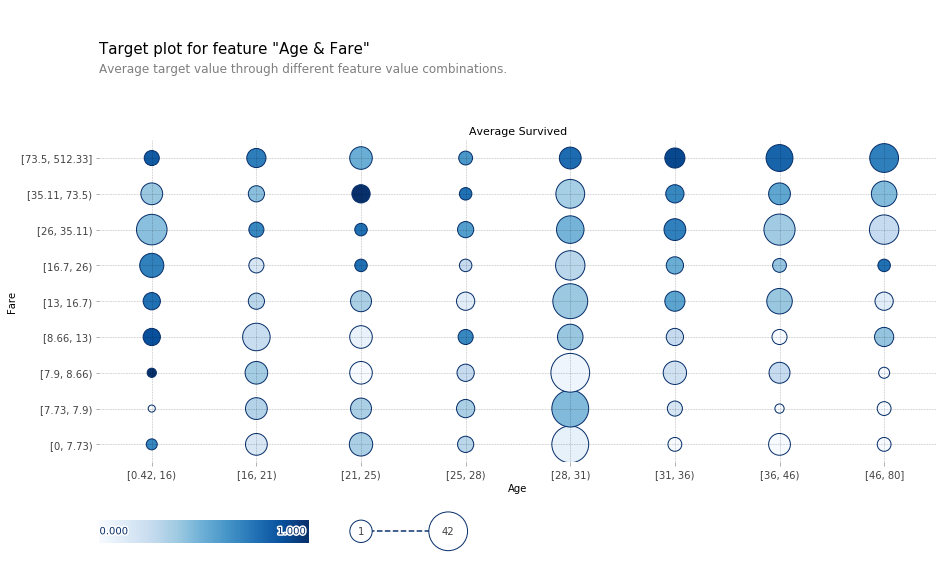

In [27]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=titanic_data, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target=titanic_target
)

In [28]:
summary_df.head()

x1  x2 display_column_1 display_column_2  value_lower_1  value_upper_1  \
0   0   0       [0.42, 16)        [0, 7.73)           0.42           16.0   
1   0   1       [0.42, 16)      [7.73, 7.9)           0.42           16.0   
2   0   2       [0.42, 16)      [7.9, 8.66)           0.42           16.0   
3   0   3       [0.42, 16)       [8.66, 13)           0.42           16.0   
4   0   4       [0.42, 16)       [13, 16.7)           0.42           16.0   

   value_lower_2  value_upper_2  count  Survived  
0       0.000000       7.732844      3  0.666667  
1       7.732844       7.895800      1  0.000000  
2       7.895800       8.662500      2  1.000000  
3       8.662500      13.000000      8  0.875000  
4      13.000000      16.700000      8  0.750000

## 4.2 prediction distribution through feature combination of 'Age' and 'Fare'

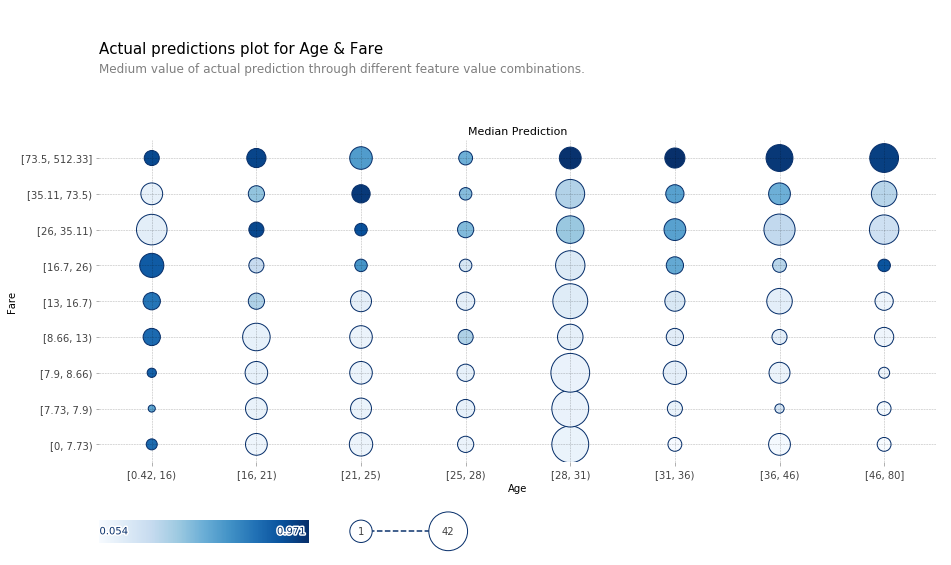

In [29]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=titanic_model, X=titanic_data[titanic_features], features=['Age', 'Fare'], feature_names=['Age', 'Fare']
)

In [30]:
summary_df.head()

x1  x2 display_column_1 display_column_2  value_lower_1  value_upper_1  \
0   0   0       [0.42, 16)        [0, 7.73)           0.42           16.0   
1   0   1       [0.42, 16)      [7.73, 7.9)           0.42           16.0   
2   0   2       [0.42, 16)      [7.9, 8.66)           0.42           16.0   
3   0   3       [0.42, 16)       [8.66, 13)           0.42           16.0   
4   0   4       [0.42, 16)       [13, 16.7)           0.42           16.0   

   value_lower_2  value_upper_2  count  actual_prediction_q1  \
0       0.000000       7.732844      3              0.512765   
1       7.732844       7.895800      1              0.552150   
2       7.895800       8.662500      2              0.756839   
3       8.662500      13.000000      8              0.690055   
4      13.000000      16.700000      8              0.603621   

   actual_prediction_q2  actual_prediction_q3  
0              0.759978              0.775501  
1              0.552150              0.552150  
2              0.799154              0.841470  
3              0.764930              0.822442  
4              0.724632              0.861933

## 4.3 pdp for feature combination of 'Age' and 'Fare'

In [31]:
inter1 = pdp.pdp_interact(
    model=titanic_model, dataset=titanic_data, model_features=titanic_features, features=['Age', 'Fare']
)

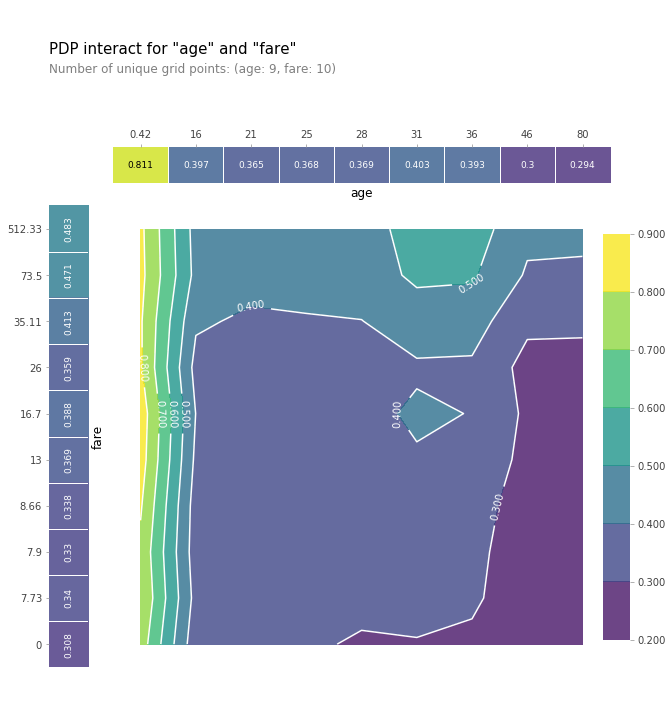

In [32]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['age', 'fare'], plot_type='contour', x_quantile=True, plot_pdp=True
)

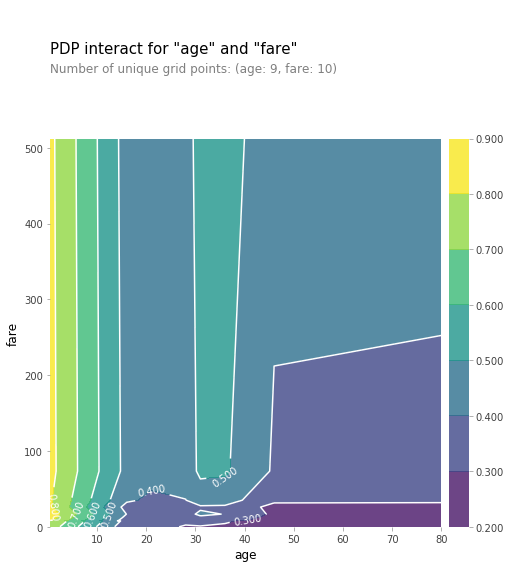

In [33]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='contour', x_quantile=False, plot_pdp=False)

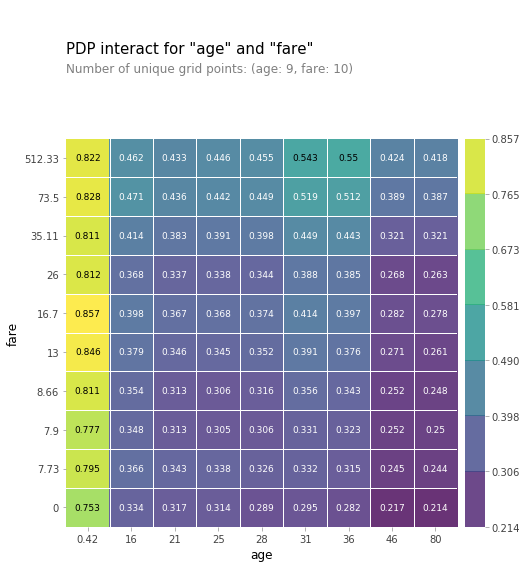

In [34]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='grid', x_quantile=True, plot_pdp=False)